In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [ ]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [ ]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# Best trials
query = {"$and": 
             [{"displayName": {"$in": ["brisk-flower-430", # NN on Rotor
                                 "quiet-night-429", #CLNN on Rotor
                                 "fragrant-pine-365", #CHNN on Rotor
                                 "sunny-feather-366", # HNN on Rotor died from NaNs
                                 "rosy-shadow-436", # LNN on Rotor stuck
                                 "magic-frost-437", # NN on Gyroscope   
                                 "gallant-durian-439", # CHNN on Gyroscope
                                 "super-vortex-440", # CLNN on Gyroscope
                                ]}
              },
              {"state": "finished"},
              {"config.network_class": {"$ne": "LNN"}},
             ]
}


runs, histories = zip(*get_history(query=query))

In [4]:
import torch

labels = []
series = []

for run in runs:
    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    network_class = run.config["network_class"]
    body_args = tuple(run.config["body_args"])
    if len(body_args) == 0:
        body_args = ""
    elif len(body_args) == 1:
        body_args = f"({body_args[0]})"
    else:
        body_args = f"{body_args}"
    body = f"{run.config['body_class']}{body_args}"

    rel_err_pred_true = ((pred_zts - true_zts).pow(2).sum((2, 3, 4)) / (pred_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
    rel_err_pert_true = ((pert_zts - true_zts).pow(2).sum((2, 3, 4)) / (pert_zts + true_zts).pow(2).sum((2,3,4))).sqrt()

    #avg_rel_err_pred = rel_err_pred_true.mean(0).numpy()
    #avg_rel_err_pert = rel_err_pert_true.mean(0).numpy()
    avg_rel_err_pred = rel_err_pred_true.cpu().numpy()
    avg_rel_err_pert = rel_err_pert_true.cpu().numpy()

    # turn into list of series from batch of series   
    series += avg_rel_err_pred.tolist()
    labels += [(body, network_class, "avg_rel_err_pred", batch) for batch in range(len(avg_rel_err_pred))]
    
    series += avg_rel_err_pert.tolist()
    labels += [(body, network_class, "avg_rel_err_pert", batch) for batch in range(len(avg_rel_err_pert))]

File already exists
File already exists
File already exists
File already exists
File already exists
File already exists


In [5]:
#index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series"))
levels = ['Body', 'Network', "Series", "Batch"]
index = pd.MultiIndex.from_tuples(labels, names=levels)
df = pd.DataFrame(series, index=index).reset_index()

In [6]:
df.head()

,Body,Network,Series,Batch,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,Gyroscope,CLNN,avg_rel_err_pred,0,7.484972e-17,0.000183,0.000302,0.000407,0.000526,0.000627,...,0.003117,0.003092,0.003046,0.003046,0.003107,0.003227,0.003419,0.003690,0.004011,0.004321
1,Gyroscope,CLNN,avg_rel_err_pred,1,6.924730e-17,0.000041,0.000110,0.000230,0.000346,0.000486,...,0.001455,0.001495,0.001448,0.001406,0.001438,0.001506,0.001596,0.001705,0.001813,0.001866
2,Gyroscope,CLNN,avg_rel_err_pred,2,9.510547e-17,0.000051,0.000167,0.000344,0.000501,0.000815,...,0.006472,0.005713,0.005198,0.004959,0.004505,0.004550,0.005527,0.007262,0.009008,0.009941
3,Gyroscope,CLNN,avg_rel_err_pred,3,9.468650e-17,0.000137,0.000231,0.000350,0.000503,0.000680,...,0.007801,0.008497,0.009145,0.009521,0.009588,0.009362,0.008867,0.008233,0.007677,0.007366
4,Gyroscope,CLNN,avg_rel_err_pred,4,9.262151e-17,0.000179,0.000306,0.000433,0.000571,0.000712,...,0.011171,0.011322,0.011683,0.012880,0.015182,0.017971,0.020208,0.021529,0.022296,0.022967


In [7]:
dt = run.config["dt"]
integration_time = run.config["integration_time"]
chunk_len = run.config["chunk_len"] * dt
n_timesteps = int(integration_time / dt)

In [8]:
df = df.rename(columns={i: dt * i for i in range(n_timesteps)})

In [9]:
df = pd.melt(df, id_vars=levels, var_name="time")

In [10]:
df = df.sort_values(by=levels)

In [11]:
sns.set(font_scale=1.25)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set1", n_colors=6, desat=.67))
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 1000

In [12]:
df["Body"].unique()

array(['Gyroscope', 'Rotor'], dtype=object)

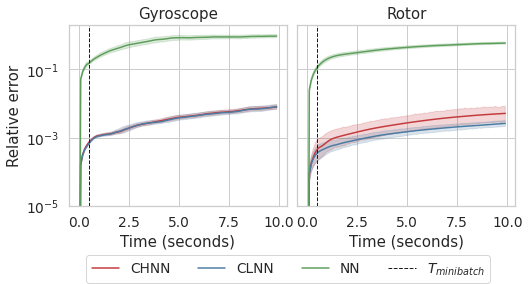

In [13]:
n_plots = len(df["Body"].unique())
fig, axes = plt.subplots(ncols=n_plots, figsize=(4 * n_plots, 4))

i = 0
for value, ax in zip(df["Body"].unique(), axes):
    data = df.loc[(df["Series"] == "avg_rel_err_pred") & (df["Body"] == value)]
    sns.lineplot(data=data, x="time", y="value", hue="Network", ax=ax, ci=95)
    ax.axvline(chunk_len, label=r"$T_{minibatch}$", color="k", linestyle="--", linewidth=1.0)
    
    ax.set(yscale="log", xlabel="Time (seconds)", title=f"{value}", ylim=(1e-5, 2))
    ax.set(ylabel="")
    
    if i > 0: # hack
        ax.set(yticklabels=[])
    
    ax.legend().remove()
    i += 1

axes[0].set(ylabel="Relative error")
handles, labels = axes[-1].get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:] # Get rid of legend title
fig.subplots_adjust(bottom=0.25, wspace=0.05, hspace=0.25)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)

In [14]:
df.head()

,Body,Network,Series,Batch,time,value
300,Gyroscope,CHNN,avg_rel_err_pert,0,0,0.000024
1500,Gyroscope,CHNN,avg_rel_err_pert,0,0.1,0.000039
2700,Gyroscope,CHNN,avg_rel_err_pert,0,0.2,0.000068
3900,Gyroscope,CHNN,avg_rel_err_pert,0,0.3,0.000097
5100,Gyroscope,CHNN,avg_rel_err_pert,0,0.4,0.000124


In [15]:
df_series = df.pivot_table(index=["Body", "Network", "Series", "Batch"], columns="time", values="value")
y = df_series.to_numpy()
geom_mean = np.exp(np.trapz(np.log(y + 1e-8), dx=dt, axis=-1) / integration_time)
df_geom_mean = pd.DataFrame(index=df_series.index, data=geom_mean, columns=["Geometric Mean"])
df_geom_mean = df_geom_mean.reset_index()

In [16]:
df_geom_mean

,Body,Network,Series,Batch,Geometric Mean
0,Gyroscope,CHNN,avg_rel_err_pert,0,0.000986
1,Gyroscope,CHNN,avg_rel_err_pert,1,0.001317
2,Gyroscope,CHNN,avg_rel_err_pert,2,0.003363
3,Gyroscope,CHNN,avg_rel_err_pert,3,0.001729
4,Gyroscope,CHNN,avg_rel_err_pert,4,0.001333
...,...,...,...,...,...
1195,Rotor,NN,avg_rel_err_pred,95,0.246885
1196,Rotor,NN,avg_rel_err_pred,96,0.324874
1197,Rotor,NN,avg_rel_err_pred,97,0.686886
1198,Rotor,NN,avg_rel_err_pred,98,0.285897


In [17]:
n_test = df["Batch"].nunique()

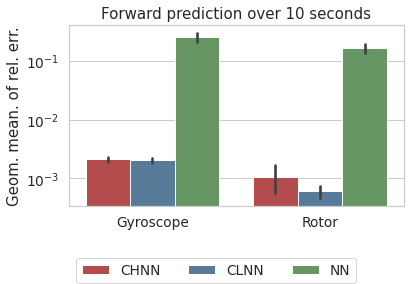

In [22]:
fig, ax = plt.subplots()
sns.barplot(data=df_geom_mean, x="Body", y="Geometric Mean",
             ci=95, hue="Network", ax=ax)
ax.set(yscale="log", ylabel="Geom. mean. of rel. err.", xlabel=None,
       title=f"Forward prediction over {integration_time} seconds")
ax.legend().remove()

xlabels = [f"{system}" for system in df_geom_mean["Body"].unique()]
ax.set_xticklabels(xlabels, rotation=0)

handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(bottom=0.25)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)

In [49]:
fig.savefig("data-efficiency.pdf", bbox_inches="tight")